In [1]:
import pandas as pd
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join('.', 'src')))

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from scipy.stats import norm
import random

from GaussianProcess import GP

from matplotlib import pyplot as plt
%matplotlib inline

# Other notes:
# https://www.kaggle.com/mpearmain/bnp-paribas-cardif-claims-management/bayesianoptimization-of-random-forest/code
# http://www.cse.wustl.edu/~garnett/cse515t/files/lecture_notes/12.pdf

# Minimize

In this notebook, we look at two acquisition functions:
### Probability of improvement

Define: 

$$\gamma(x) = \frac{y^* - \mu(x)}{\sigma(x)}$$ 
and  
$$\Phi(x) = \frac{1}{2 \pi}\int_{-\infty}^{x} E^\frac{-t^2}{2}dt$$

Then: $$PI_{y^*}(x) = \Phi(\gamma(x))$$

### Expected improvement
$$EI_{y^*}(x) = \int_{-\infty}^{\infty} \max(y^* - y, 0) p_M(y|x)dy$$
$$ = \sigma(x) (\gamma(x) \Phi(x) + \mathcal{N}(\gamma(x); 0, 1)$$

Source [here](https://arxiv.org/pdf/1206.2944.pdf).

In [2]:
def myround(x, prec=6, base=.05):
    return round(base * round(float(x)/base),prec)

def gamma(mu, sd, ybest):
    return np.subtract(ybest, mu)/sd

def phi(gx):
    return norm.cdf(gx)

def PI(ybest, mu, sd, explore = .5):
    # Probability of "doing better than" ybest.
    #
    # Math:
    #  CDF of standard normal
    #  integrated from -inf to (ybest - (predicted value))/sd(prediction)
    #
    # Rewards "small, certain improvements" 
    # more than "big, risky improvements".
    return phi(gamma(mu, sd, ybest + explore))

def EI(ybest, mu, sd):
    # How much "better than" ybest we think we can do.
    # Cares about the size of the improvement. 
    gammas = gamma(mu, sd, ybest)
    return np.multiply(sd, np.multiply(gammas, phi(gammas)) + norm.pdf(gammas))

def one_round_optimize(grid, step, ybest, gp, acquisition_fn = "PI"):
    
    # Points to assess:
    noisygrid = np.unique(grid + np.array([myround(x, base = step) for x in np.random.rand(len(grid))]))
    
    # Compute mean and sd for the points in the grid:
    predicted = [gp.get_new_preds(x) for x in noisygrid]
    mu        = np.array([x for x, _, _, _ in predicted])
    sd        = np.array([sd if not np.isnan(sd) else 0 for _, _, _, sd in predicted ])

    if acquisition_fn == "PI":
        to_max = PI(ybest, mu, sd)
    elif acquisition_fn == "EI":
        to_max = EI(ybest, mu, sd)
    
    return noisygrid[np.where((lambda f: f == np.nanmax(f))(to_max))][0]

def minimize(params): 
    #######################################################
    # Defaults:
    # - squared exponential prior
    # - number of 'startup rounds' = 10
    # - acquisition fn is Expected Improvement
    #######################################################
    if "cov" not in params.keys():
        params["cov"] = (lambda x1, x2: np.exp(-.5 * np.linalg.norm(np.subtract(x2, x1))**2)/(2*.01))
    if "nstart" not in params.keys():
        params["nstart"] = 10
    if "acquisition_fn" not in params.keys():
        params["acquisition_fn"] = "EI"

    #######################################################
    # Initialize the GP and define the sample space.
    # Not efficient. We materialize the whole sample space!
    #######################################################
    gp = GP(params["cov"]); 
    grid = [x for x in np.arange(params["bound_low"], params["bound_high"], params["step_size"])]
    
    #######################################################
    # Observe (randomly) some initial points
    #######################################################
    X = random.sample(grid, params["nstart"]) 
    y = np.array([params["function"](x) for x in X])
    gp.observe(X, y)

    #######################################################
    # And optimize!
    #######################################################
    ybest = min(y)
    for i in range(params["rounds"]):
        recommended = one_round_optimize(grid, params["step_size"], ybest, gp, params["acquisition_fn"])
        new         = params["function"](recommended)
        gp.observe([recommended], [new])
        if new < ybest:
            ybest = new
    
    return {"BestX": gp.X[np.where(gp.y == min(gp.y))][0], "BestY": min(gp.y), "GP": gp}

# Examples

## Minimize $x^2$:

### EI

In [3]:
# Expected improvement
params = {
    "bound_low": -10, "bound_high": 10, "step_size":  .1,
    "rounds":     50, "nstart":     10,
    "function":   (lambda x: x**2),
    "cov":        (lambda x1, x2: np.exp(-.5 * np.linalg.norm(np.subtract(x2, x1))**2)/(2*.01)), # squared exponential
    "acquisition_fn":"EI"
}

res = minimize(params)
res

{'BestX': -3.2640556923979602e-14,
 'BestY': 1.0654059563075528e-27,
 'GP': <GaussianProcess.GP at 0x10c06a748>}

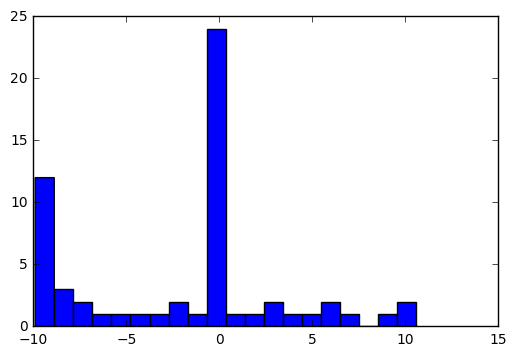

In [4]:
# Where did we sample?
plt.hist(res['GP'].X, bins=20);

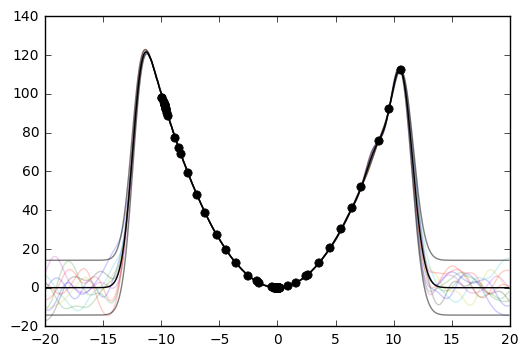

In [5]:
# What does the GP look like?
gp = res['GP']
gp.sample([x for x in np.arange(-20, 20, .1)], 10)
gp.plot(); 

### PI

In [6]:
# Probability of improvement:
params["acquisition_fn"] = "PI"

res = minimize(params)
res

{'BestX': 0.099999999999967004,
 'BestY': 0.0099999999999934013,
 'GP': <GaussianProcess.GP at 0x10c4c7630>}

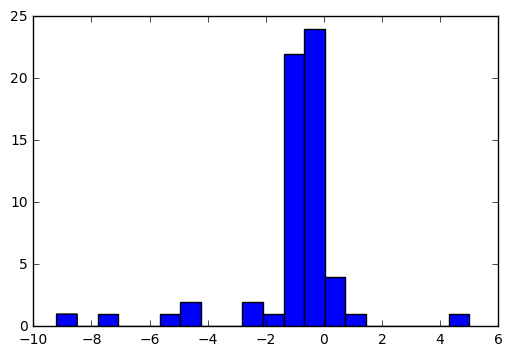

In [7]:
# Where did we sample?
plt.hist(res['GP'].X, bins=20);

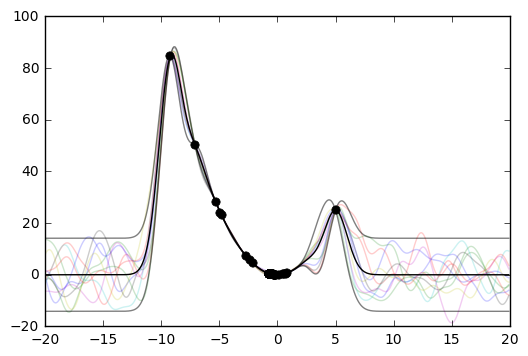

In [8]:
# What does the GP look like?
gp = res['GP']
gp.sample([x for x in np.arange(-20, 20, .1)], 10)
gp.plot(); 

## Minimize sin(x) over 0, 15

### EI

In [9]:
# Expected improvement
params = {
    "bound_low": 0, "bound_high": 15, "step_size":  .1,
    "rounds":     50, "nstart":     10,
    "function":   (lambda x: np.sin(x)),
    "cov":        (lambda x1, x2: np.exp(-.5 * np.linalg.norm(np.subtract(x2, x1))**2)/(2*.01)), # squared exponential
    "acquisition_fn":"EI"
}

res = minimize(params)
res

{'BestX': 11.0,
 'BestY': -0.99999020655070348,
 'GP': <GaussianProcess.GP at 0x10c4fd470>}

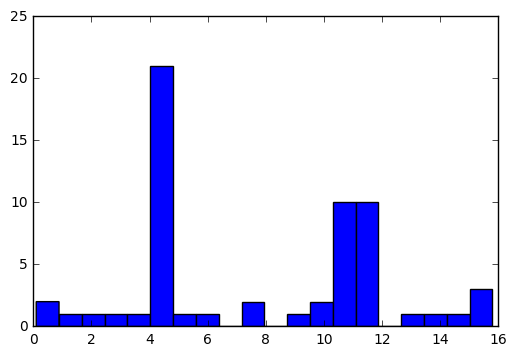

In [10]:
# Where did we sample?
plt.hist(res['GP'].X, bins=20);

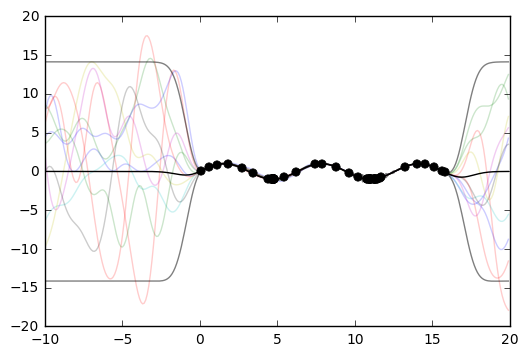

In [11]:
# What does the GP look like?
gp = res['GP']
gp.sample([x for x in np.arange(-10, 20, .1)], 10)
gp.plot(); 

### PI

In [12]:
# Probability of improvement:
params["acquisition_fn"] = "PI"

res = minimize(params)
res

{'BestX': 4.7999999999999998,
 'BestY': -0.99616460883584068,
 'GP': <GaussianProcess.GP at 0x1085b4978>}

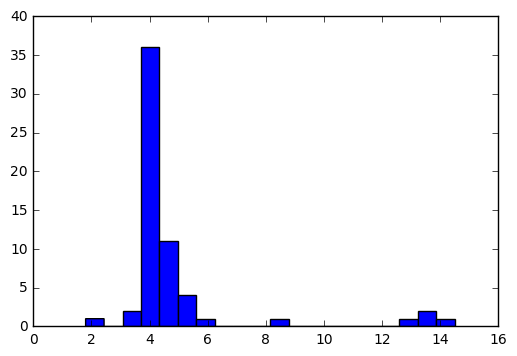

In [13]:
# Where did we sample?
plt.hist(res['GP'].X, bins=20);

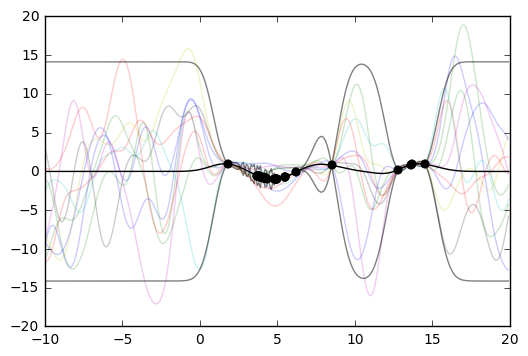

In [14]:
# What does the GP look like?
gp = res['GP']
gp.sample([x for x in np.arange(-10, 20, .1)], 10)
gp.plot(); 

# Questions

- How do we actually choose next point (do we really look at a whole grid)?
- Intractability of covariance matrix size?
